## 1: Bandits

### 1.1A: Epsilon Greedy

In [1]:
import numpy as np
import sys
if "../" not in sys.path:
    sys.path.append("../") 

In [2]:

### Interface
class Environment(object):

    def reset(self):
        raise NotImplementedError('Inheriting classes must override reset.')

    def actions(self):
        raise NotImplementedError('Inheriting classes must override actions.')

    def step(self):
        raise NotImplementedError('Inheriting classes must override step')

class ActionSpace(object):
    
    def __init__(self, actions):
        self.actions = actions
        self.n = len(actions)
    
        
class BanditEnv(Environment):
    def __init__(self, num_actions = 10, distribution = "bernoulli", evaluation_seed=44):
        super(BanditEnv, self).__init__()
        
        self.action_space = ActionSpace(range(num_actions))
        self.distribution = distribution
        
        if (evaluation_seed != 44):
            np.random.seed(evaluation_seed)
        
        self.reward_parameters = None
        if distribution == "bernoulli":
            self.reward_parameters = np.random.rand(num_actions)
        elif distribution == "normal":
            self.reward_parameters = (np.random.randn(num_actions), np.random.rand(num_actions))
        elif distribution == "heavy-tail":
            self.reward_parameters = np.random.rand(num_actions)
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
        
        if distribution != "normal":
            self.optimal_arm = np.argmax(self.reward_parameters)
        else:
            self.optimal_arm = np.argmax(self.reward_parameters[0])
            
        #print("Distribution:", distribution, self.reward_parameters, flush = True)
        #print("Optimal arm:", self.optimal_arm, flush = True)
    
    def reset(self):
        self.is_reset = True
        return None
    
    def compute_gap(self, action):
        if self.distribution != "normal":
            gap = np.absolute(self.reward_parameters[self.optimal_arm] - self.reward_parameters[action])
        else:
            gap = np.absolute(self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action])
        return gap
    
    def step(self, action):
        self.is_reset = False
        
        valid_action = True
        if (action is None or action < 0 or action >= self.action_space.n):
            print("Algorithm chose an invalid action; reset reward to -inf", flush = True)
            reward = float("-inf")
            gap = float("inf")
            valid_action = False
        
        if self.distribution == "bernoulli":
            if valid_action:
                reward = np.random.binomial(1, self.reward_parameters[action])
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]
        elif self.distribution == "normal":
            if valid_action:
                reward = self.reward_parameters[0][action] + self.reward_parameters[1][action] * np.random.randn()
                gap = self.reward_parameters[0][self.optimal_arm] - self.reward_parameters[0][action]
        elif self.distribution == "heavy-tail":
            if valid_action:
                reward = self.reward_parameters[action] + np.random.standard_cauchy()
                gap = self.reward_parameters[self.optimal_arm] - self.reward_parameters[action]        #HACK to compute expected gap
        else:
            print("Please use a supported reward distribution", flush = True)
            sys.exit(0)
            
        return(None, reward, self.is_reset, '')

In [3]:
#Policy interface
class Policy:
    #num_actions: (int) Number of arms [indexed by 0 ... num_actions-1]
    def __init__(self, num_actions):
        self.num_actions = num_actions
    
    def act(self):
        pass
        
    def feedback(self, action, reward):
        pass

In [4]:
#Greedy policy
class Greedy(Policy):
    def __init__(self, num_actions):
        Policy.__init__(self, num_actions)
        self.name = "Greedy"
        self.total_rewards = np.zeros(num_actions, dtype = np.longdouble)
        self.total_counts = np.zeros(num_actions, dtype = np.longdouble)
    
    def act(self):
        current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
        current_averages[self.total_counts <= 0] = 0.5      #Correctly handles Bernoulli rewards; over-estimates otherwise
        current_action = np.argmax(current_averages)
        return current_action
        
    def feedback(self, action, reward):
        self.total_rewards[action] += reward
        self.total_counts[action] += 1

Now let's implement an epsilon greedy policy based on the policy interface. The epsilon greedy policy will make sure we explore (i.e taking random actions) as set by the epsilon value, and take the most rewarding action (i.e greedy) the rest of the times. This is implemented in the act() function. 

In [5]:
#Epsilon Greedy policy
class EpsilonGreedy(Greedy):
    def __init__(self, num_actions, epsilon):
        Greedy.__init__(self, num_actions)
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
            
        self.epsilon = epsilon
        self.name = "Epsilon Greedy"
    
    def act(self):
        choice = None
        if self.epsilon == 0:
            choice = 0
        elif self.epsilon == 1:
            choice = 1
        else:
            choice = np.random.binomial(1, self.epsilon)
            
        if choice == 1:
            return np.random.choice(self.num_actions)
        else:
            current_averages = np.divide(self.total_rewards, self.total_counts, where = self.total_counts > 0)
            #current_averages[self.total_counts <= 0] = 0.5  #Correctly handles Bernoulli rewards; over-estimates otherwise
            current_action = np.argmax(current_averages)
            return current_action
        

Now let's prepare the simulation. We'll use a different seed and have 10 arms/actions instead of 5.

In [6]:
from collections import namedtuple
TimestepStats = namedtuple("Stats",["cumulative_rewards", "regrets"])

In [7]:
#import lib.plotting as plotting
from matplotlib import pyplot as plt
from matplotlib import pylab

class Experiments(object):
    def __init__(self, env, agent):
        
        self.env = env
        self.agent = agent
        
        self.episode_length = np.array([0])
        self.episode_reward = np.array([0])
        
        

    def run_bandits(self, max_number_of_trials=1000, display_frequency=1):
        
        stats = TimestepStats(
            cumulative_rewards=np.zeros(max_number_of_trials),
            regrets=np.zeros(max_number_of_trials))   
            
        cumulative_reward = 0.0
        cumulative_regret = 0.0
        
        for trial in range(max_number_of_trials):
            action = self.agent.act()
            
            _ , reward, done, _ = self.env.step(action)       
            self.agent.feedback(action, reward)
            cumulative_reward += reward

            gap = self.env.compute_gap(action)
            if action != self.env.optimal_arm:
                cumulative_regret += gap

            stats.cumulative_rewards[trial] = cumulative_reward
            stats.regrets[trial] = cumulative_regret
         
        return stats

In [17]:
#evaluation_seed = 5016
num_actions = 10
trials = 1000
distribution = "bernoulli"
#distribution = "normal"

In [18]:
N = 2000
eps = [0, 0.01, 0.1]

In [19]:
es = len(eps)
Reward = np.zeros((N, es, trials))
Regret = np.zeros((N, es, trials))

In [20]:
for n in range(N):
    env = BanditEnv(num_actions, distribution)
    for ei in range(es):
        agent = EpsilonGreedy(num_actions, eps[ei])
        experiments = Experiments(env, agent)
        tmp = experiments.run_bandits(trials)
        Reward[n, ei, :] = tmp.cumulative_rewards
        Regret[n, ei, :] = tmp.regrets

In [21]:
reward = np.mean(Reward, axis=0)
regret = np.mean(Regret, axis=0)

In [22]:
reward.shape

(3, 1000)

In [23]:
regret.shape

(3, 1000)

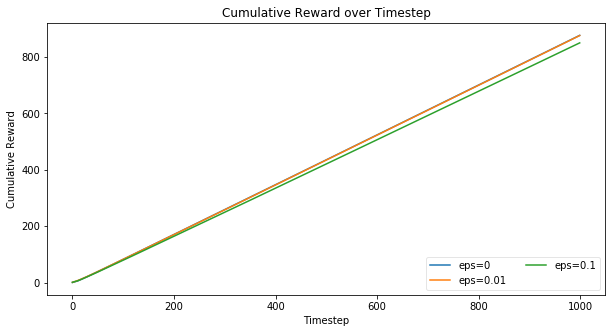

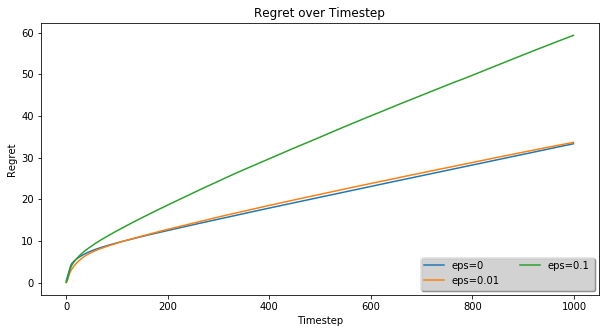

In [24]:
fig1 = plt.figure(figsize=(10,5))
plt.plot(reward[0, :], label=f"eps={eps[0]}")
plt.plot(reward[1, :], label=f"eps={eps[1]}")
plt.plot(reward[2, :], label=f"eps={eps[2]}")
plt.xlabel("Timestep")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Timestep")
leg = plt.legend(loc='lower right', ncol=2, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.show(fig1)

# Plot the regret over time
fig2 = plt.figure(figsize=(10,5))
plt.plot(regret[0, :], label=f"eps={eps[0]}")
plt.plot(regret[1, :], label=f"eps={eps[1]}")
plt.plot(regret[2, :], label=f"eps={eps[2]}")
plt.xlabel("Timestep")
plt.ylabel("Regret")
plt.title("Regret over Timestep")
leg = plt.legend(loc='lower right', ncol=2, shadow=True, fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.show(fig2)